In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# lA ID de la GPU a usar, puede ser desde 0 hasta las N GPU's. Si es -1 significa que es en la CPU
os.environ["CUDA_VISIBLE_DEVICES"]="1";

# Importacion de librerias

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import warnings
warnings.filterwarnings("ignore")

import argparse
import tensorflow as tf
from IPython.display import display, clear_output
from random import randint

# Configuraciones de TensorFlow

In [3]:
config = tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth = True

### Modo eagerly

In [3]:
#Comprobar que estoy ejecutandome en modo eagerly
tf.executing_eagerly()

True

# Carga de Datos

In [4]:
root_path = "/home/jefelitman/DataSets/ucf101/split_1"
root_path

'/home/jefelitman/DataSets/ucf101/split_1'

In [12]:
#with tf.compat.v1.device("/CPU:0"):
batch = 15
original_size = [342,256]
size = None
frames = 15
canales = 3

In [13]:
import sys
sys.path.append('../')

#with tf.compat.v1.device("/CPU:0"):
from Datasets_utils.DatasetsLoader import VideoDataGenerator

dataset = VideoDataGenerator(directory_path = root_path, 
                             batch_size = batch, 
                             original_frame_size = original_size, 
                             frame_size=size, 
                             video_frames = frames, 
                             temporal_crop = (None, None), 
                             frame_crop = (None, None), 
                             shuffle = False, 
                             conserve_original = False)

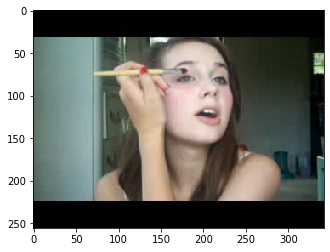

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2

img = cv2.imread('/home/jefelitman/DataSets/ucf101/split_1/train/ApplyEyeMakeup/v_applyeyemakeup_g08_c01/frame000001.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [14]:
batch, labels = dataset.get_next_train_batch()
batch.shape

(15, 15, 256, 342, 3)

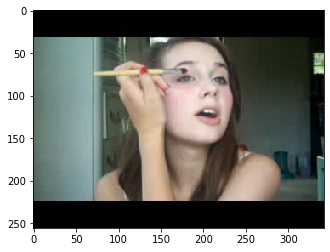

In [15]:
plt.imshow(batch[0,0].astype(np.uint8))

In [25]:
img.shape[1::-1]

(342, 256)

In [8]:
dataset.train_data[0]

{('tcrop0icrop13320',
  <bound method VideoDataGenerator.resize_frame of <Datasets_utils.DatasetsLoader.VideoDataGenerator object at 0x7ff22f6b0630>>): (['/home/jefelitman/DataSets/ucf101/split_1/train/ApplyEyeMakeup/v_applyeyemakeup_g08_c01/frame000001.jpg',
   '/home/jefelitman/DataSets/ucf101/split_1/train/ApplyEyeMakeup/v_applyeyemakeup_g08_c01/frame000002.jpg',
   '/home/jefelitman/DataSets/ucf101/split_1/train/ApplyEyeMakeup/v_applyeyemakeup_g08_c01/frame000003.jpg',
   '/home/jefelitman/DataSets/ucf101/split_1/train/ApplyEyeMakeup/v_applyeyemakeup_g08_c01/frame000004.jpg',
   '/home/jefelitman/DataSets/ucf101/split_1/train/ApplyEyeMakeup/v_applyeyemakeup_g08_c01/frame000005.jpg',
   '/home/jefelitman/DataSets/ucf101/split_1/train/ApplyEyeMakeup/v_applyeyemakeup_g08_c01/frame000006.jpg',
   '/home/jefelitman/DataSets/ucf101/split_1/train/ApplyEyeMakeup/v_applyeyemakeup_g08_c01/frame000007.jpg',
   '/home/jefelitman/DataSets/ucf101/split_1/train/ApplyEyeMakeup/v_applyeyemakeup_g08

# Red Neuronal

In [8]:
from LTC import LTC

#with tf.compat.v1.device("/GPU:0"):
Sesion = tf.Session(config=config)

video_shape = [frames] + size + [canales]

ltc = LTC(101,batch,video_shape)

ltc.enable_training()

W1108 23:02:10.007308 140125203068736 deprecation_wrapper.py:119] From /home/jefelitman/Biv2LabNN/LTC/LTC.py:15: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



In [9]:
#with tf.compat.v1.device("/CPU:0"):
ltc.inicializar_modelo(0.003,0.5)
init = tf.global_variables_initializer()
Sesion.run(init)

W1108 23:02:20.155591 140125203068736 deprecation_wrapper.py:119] From /home/jefelitman/Biv2LabNN/LTC/LTC.py:112: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W1108 23:02:20.157610 140125203068736 deprecation_wrapper.py:119] From /home/jefelitman/Biv2LabNN/LTC/LTC.py:113: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.

W1108 23:02:20.159083 140125203068736 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1108 23:02:20.210742 140125203068736 deprecation_wrapper.py:119] From /home/jefelitman/Biv2LabNN/LTC/LTC.py:157: The name tf.nn.xw_plus_b is deprecated. Please use tf.compat.v1.nn.xw_plus_b instea

In [10]:
#Como es primera ver corriendo este modelo entonces no debo cargar nada
saver = tf.train.Saver()
step = 1
train_epoch = 1
test_epoch = 1
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []
while True:
    #Primero voy salvando el modelo de 40000 en 40000
    if step % 1000 == 0:
        saved_path = saver.save(Sesion, '../Checkpoints/LTC_112x112x60_rgb_batch15/LTC_112x112x60_rgb')
        print('Modelo salvado en: {}'.format(saved_path))
        
    if step == 80000 or step == 125000:
        ltc.lr = ltc.lr * 0.1
    
    if step % 5 == 0:
        clear_output(wait=True)
        print(" Step: ",step)
        print("Train Epoch: ",train_epoch, " Train batch: ",dataset.train_batch_index+1,"/",dataset.train_batches)
        print("Train_Loss: ",train_loss[-1]," Train_Acuraccy: ",train_accuracy[-1])
        print("Test Epoch: ",test_epoch," Test batch: ",dataset.test_batch_index+1,"/",dataset.test_batches)
        print("Test_Loss: ",test_loss[-1]," Test_Acuraccy: ",test_accuracy[-1])
    
    if dataset.train_batch_index == dataset.train_batches:
        train_epoch += 1
        
    if dataset.test_batch_index == dataset.test_batches:
        test_epoch += 1
    
    #Entreno con datos de entrenamiento
    batch, labels = dataset.get_next_train_batch(canales)
    Sesion.run(ltc.entrenar,feed_dict={ltc.x: batch, ltc.y: labels})
    train_loss.append(Sesion.run(ltc.perdida,feed_dict={ltc.x: batch, ltc.y: labels}))
    train_accuracy.append(Sesion.run(ltc.precision,feed_dict={ltc.x: batch, ltc.y: labels}))
    
    #Pruebo con datos de test
    batch, labels = dataset.get_next_test_batch(canales)
    test_loss.append(Sesion.run(ltc.perdida,feed_dict={ltc.x: batch, ltc.y: labels}))
    test_accuracy.append(Sesion.run(ltc.precision,feed_dict={ltc.x: batch, ltc.y: labels}))
    
    step += 1

ResourceExhaustedError: OOM when allocating tensor with shape[64,60,112,112,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node conv1/conv1 (defined at /home/jefelitman/Biv2LabNN/LTC/LTC.py:121) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Errors may have originated from an input operation.
Input Source operations connected to node conv1/conv1:
 conv1/W/read (defined at /home/jefelitman/Biv2LabNN/LTC/LTC.py:116)	
 Entradas (defined at /home/jefelitman/Biv2LabNN/LTC/LTC.py:15)

Original stack trace for 'conv1/conv1':
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.6/dist-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 438, in run_forever
    self._run_once()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 1451, in _run_once
    handle._run()
  File "/usr/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/usr/local/lib/python3.6/dist-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/usr/local/lib/python3.6/dist-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/usr/local/lib/python3.6/dist-packages/tornado/gen.py", line 781, in inner
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/tornado/gen.py", line 742, in run
    yielded = self.gen.send(value)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/usr/local/lib/python3.6/dist-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/usr/local/lib/python3.6/dist-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/usr/local/lib/python3.6/dist-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 3214, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-567960267ba4>", line 2, in <module>
    ltc.inicializar_modelo(0.003,0.5)
  File "/home/jefelitman/Biv2LabNN/LTC/LTC.py", line 29, in inicializar_modelo
    self.__construir_modelo__()
  File "/home/jefelitman/Biv2LabNN/LTC/LTC.py", line 36, in __construir_modelo__
    conv1 = self.__convolucion_3d__('conv1', self.x, 3, self.x.shape[4], 64, self.__formateo_stride__(1, 1, 1))
  File "/home/jefelitman/Biv2LabNN/LTC/LTC.py", line 121, in __convolucion_3d__
    name=nombre_operacion)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_ops.py", line 2403, in conv3d_v1
    input, filter, strides, padding, data_format, dilations, name)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gen_nn_ops.py", line 1553, in conv3d
    dilations=dilations, name=name)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py", line 3616, in create_op
    op_def=op_def)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py", line 2005, in __init__
    self._traceback = tf_stack.extract_stack()


In [ ]:
max(train_accuracy)

In [ ]:
max(test_accuracy)